<a href="https://colab.research.google.com/github/Dario66/Deep-Learning/blob/main/ProjectFruit360Dario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installo Kaggle

In [1]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Scarico il Fruits 360 dataset

In [21]:
! kaggle datasets download -d moltean/fruits

100% 1.28G/1.28G [00:07<00:00, 199MB/s]
100% 1.28G/1.28G [00:07<00:00, 180MB/s]


Estraggo lo zip e elimino il file

In [ ]:
! unzip fruits.zip

! rm fruits.zip

Importo le librerie necessarie

In [23]:
from keras.layers.normalization.batch_normalization import BatchNormalization 
import tensorflow as tf
from torchsummary import summary
from sklearn.model_selection import KFold, train_test_split
from statistics import mean
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import random
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, LSTM
from collections import Counter
import numpy as np
from glob import glob
from google.colab import drive
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from sklearn.datasets import load_files
from keras.utils import np_utils
import cv2
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import regularizers

Stampo i 75 frutti con numero maggiore di esemplari

In [24]:
path_to_train = 'fruits-360_dataset/fruits-360/Training'
path_to_test = 'fruits-360_dataset/fruits-360/Test'
#numero di campioni per ogni frutto
fruits = []
fruits_image = []
for i in os.listdir(path_to_train):
    for image_filename in os.listdir(path_to_train+'/' + i):
        fruits.append(i) 
        fruits_image.append(i + '/' + image_filename)
newData = Counter(fruits)
frequent_fruits = newData.most_common(30)
frequent_fruits



[('Grape Blue', 984),
 ('Plum 3', 900),
 ('Cherry 2', 738),
 ('Strawberry Wedge', 738),
 ('Cherry Rainier', 738),
 ('Tomato 1', 738),
 ('Melon Piel de Sapo', 738),
 ('Peach 2', 738),
 ('Tomato 3', 738),
 ('Walnut', 735),
 ('Pear Stone', 711),
 ('Cauliflower', 702),
 ('Fig', 702),
 ('Pear Forelle', 702),
 ('Pepper Orange', 702),
 ('Pear 2', 696),
 ('Tomato Heart', 684),
 ('Apple Red Yellow 2', 672),
 ('Tomato 2', 672),
 ('Pepper Red', 666),
 ('Pear Red', 666),
 ('Pepper Yellow', 666),
 ('Nut Forest', 654),
 ('Nut Pecan', 534),
 ('Pineapple Mini', 493),
 ('Cherry 1', 492),
 ('Grape White 3', 492),
 ('Mulberry', 492),
 ('Grapefruit White', 492),
 ('Apple Golden 2', 492)]

Elimino le cartelle delle classi che non vogliamo utilizzare nel nostro set di train e test

In [25]:
from inspect import EndOfBlock
import shutil
for filename in os.listdir("fruits-360_dataset/fruits-360/Training"):
    f = os.path.join("fruits-360_dataset/fruits-360/Training/", filename)
    # checking if it is a filec
    #if os.path.isdir(f):
    d = dict(frequent_fruits)
    #print(list1)
    #for key in d:
       #print(key)
    if filename in d:
       #print(filename)
       #print(filename)
       continue
     
    #print(filename)
    shutil.rmtree("fruits-360_dataset/fruits-360/Training/"+str(filename), ignore_errors=False, onerror=None)
    shutil.rmtree("fruits-360_dataset/fruits-360/Test/"+str(filename), ignore_errors=False, onerror=None)
    #print(f)
       #os.remove(filename) 
       #os.remove(f) 

#os.rmdir("fruits-360_dataset/fruits-360/Training/Clementine")    

Found 20167 files belonging to 30 classes.
Using 16134 files for training.
Found 6725 files belonging to 30 classes.
Using 1345 files for validation.
['Apple Golden 2', 'Apple Red Yellow 2', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Fig', 'Grape Blue', 'Grape White 3', 'Grapefruit White', 'Melon Piel de Sapo', 'Mulberry', 'Nut Forest', 'Nut Pecan', 'Peach 2', 'Pear 2', 'Pear Forelle', 'Pear Red', 'Pear Stone', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Pineapple Mini', 'Plum 3', 'Strawberry Wedge', 'Tomato 1', 'Tomato 2', 'Tomato 3', 'Tomato Heart', 'Walnut']
Numero di Label:30
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_15 (Rescaling)    (None, 100, 100, 3)       0         
                                             

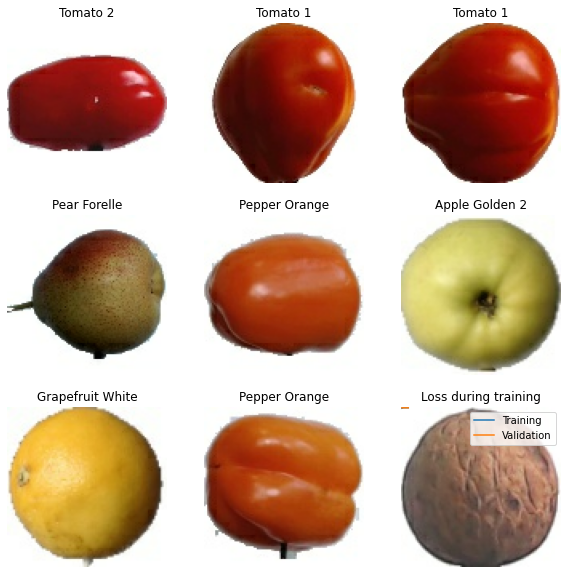

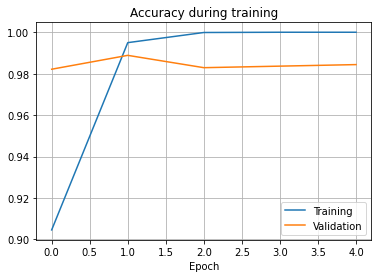

In [33]:
from keras.layers.normalization.batch_normalization import BatchNormalization
import tensorflow as tf
from torchsummary import summary
from sklearn.model_selection import KFold, train_test_split
from statistics import mean
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import random
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, LSTM, Rescaling
from collections import Counter
import numpy as np
from glob import glob
from google.colab import drive
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from sklearn.datasets import load_files
from keras.utils import np_utils
import cv2
from keras.models import Model
import pathlib
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import RandomFlip, RandomRotation, RandomZoom
# We can also use the history (that we saved before) to check the behavior of the training.
# history is a Python dictionary that cointains the values of the behavior of the loss
# during training (one value for each epoch).
def display_history(history):
    mse_training = history.history['loss']
    acc_training = history.history['accuracy']

    mse_val = history.history['val_loss']
    acc_val = history.history['val_accuracy']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()



path_to_train = 'fruits-360_dataset/fruits-360/Training'
path_to_test = 'fruits-360_dataset/fruits-360/Test'


data_dir = pathlib.Path(path_to_test)

batch_size = 32
epoch=10
d1 = 100
d2 = 100



validation_steps = 14145//batch_size # if you have validation data 
validation_steps=110


seed = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
  path_to_train,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(d1, d2),
  batch_size=batch_size)

validation_ds = tf.keras.utils.image_dataset_from_directory(
  path_to_test,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(d1, d2),
  batch_size=batch_size)

#steps_per_epoch = len(list(train_ds))//batch_size


class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print ('Numero di Label:'+str(num_classes))

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

data_augmentation = lambda input_shape: tf.keras.Sequential([
    RandomFlip("horizontal", input_shape=input_shape),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

def get_model(input_shape):
    x = Input(shape=input_shape)
    #augmented = (data_augmentation(input_shape))(x)

    #r = Rescaling(1./255)(augmented)
    r = Rescaling(1./255)(x)
    c1 = Conv2D(16, 3, padding='same', activation='relu')(r)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, 3, padding='same', activation='relu')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, 3, padding='same', activation='relu')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    d = Dropout(.2)(p3)
    f = Flatten()(d)
    d1 = Dense(128, activation='relu')(f)
    d2 = Dense(num_classes)(d1)


    model = Model(x, d2)

    model.summary()
    
    return model


callback = EarlyStopping(monitor="val_accuracy",
    mode = "max",
    min_delta=0.001,
    patience=3,
    restore_best_weights=True)
#, callbacks = [callback]

import keras.backend as K
import tensorflow as tf
accepted_diff = 0.01
def linear_regression_equality(y_true, y_pred):
    diff = K.abs(y_true-y_pred)
    return K.mean(K.cast(diff < accepted_diff, tf.float32))

model = get_model((d1, d2, 3))


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=loss_fn, metrics=['accuracy'])


history = model.fit(train_ds, epochs=epoch, validation_data = validation_ds, callbacks = [callback])

score=model.evaluate(validation_ds)
score
print(f"Model Accuracy: %{score[1]*100}")

np.save('my_history.npy',history.history)
display_history(history)

In [ ]:
path_to_train = 'fruits-360_dataset/fruits-360/Training'
path_to_test = 'fruits-360_dataset/fruits-360/Test'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        path_to_train,
        target_size=(100, 100),
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        path_to_test,
        target_size=(100, 100),
        class_mode='categorical')


train_generator.image_shape[0]
test_generator.image_shape[0]

model = Sequential()
model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5)) # helps prevent overfitting
model.add(Dense(131)) # output
model.add(Activation("softmax"))


model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

callback = EarlyStopping(monitor='val_loss', patience=10, verbose=2)

learning_model=model.fit(train_generator,steps_per_epoch=50,epochs=30,validation_data=test_generator,validation_steps=25,callbacks=callback)

learning_model.history.keys()

score=learning_model.model.evaluate(test_generator)
score
print(f"Model Accuracy: %{score[1]*100}")

